In [115]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# Libreria para estimar regresión
import statsmodels.api as sm

# Para forwad selection
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

In [116]:
url = 'https://raw.githubusercontent.com/xlisouski/DataCoder/main/train.csv'
df = pd.read_csv(url, sep = ',')

In [117]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Filter Feature Selection 
## Correlación con el Target
Se calcula el coeficiente de correlación de los Features con el target y se ordena de mayor a menor valor absoluto. 
<br>
**Aclaración:** Sólo sirve para features numéricas, así que en caso de ser categóricas combiene realizar alguna transformación. 

In [118]:
# Calculo matriz de correlación 
matriz_correlacion = df.corr(method='pearson')
# Selecciono a la variable target para estudiar únicamente correlación con ella 
matriz_correlacion_target = matriz_correlacion['SalePrice']
# Calculo valor absoluto, para extraer correlaciones más fuertes independientemente de su sentido 
matriz_correlacion_target = abs(matriz_correlacion_target)
# Menciono columnas que quiero excluir del análisis de correlación 
columnas_a_excluir = ['SalePrice', 'SalePrice']
# Las excluyo del análisis
matriz_correlacion_target = matriz_correlacion_target.drop(columns=columnas_a_excluir, index=columnas_a_excluir)
# Ordeno de mayor a menor correlacion 
matriz_correlacion_target = matriz_correlacion_target.sort_values(ascending=False)

C:\Users\usernosis\AppData\Local\Temp\ipykernel_9212\2489381718.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matriz_correlacion = df.corr(method='pearson')


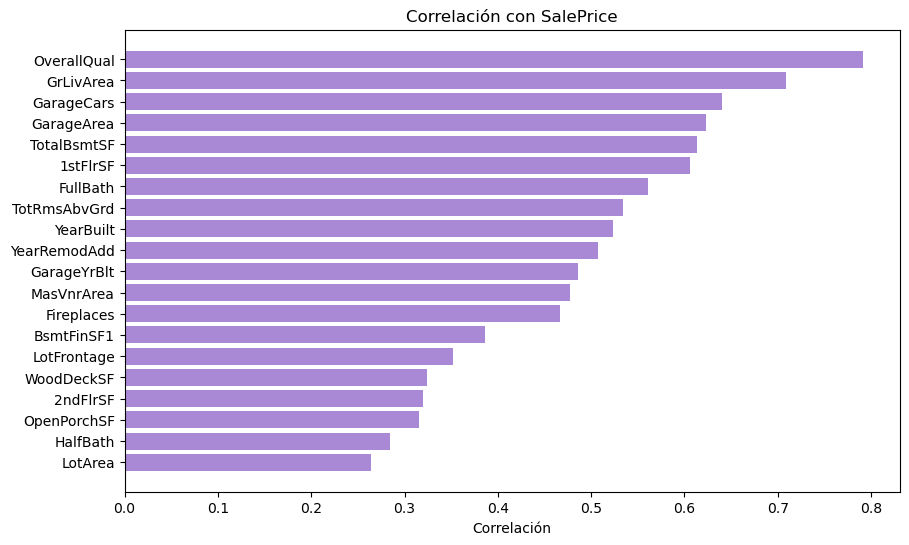

In [119]:
# Grafico el top 20 de variables más correlacionadas
matriz_correlacion_target_graficar = matriz_correlacion_target[0:20]
plt.figure(figsize=(10, 6))  # Tamaño de la figura
plt.barh(matriz_correlacion_target_graficar.index, 
         matriz_correlacion_target_graficar.values,
         color = '#A989D6')
plt.xlabel('Correlación')
plt.title('Correlación con SalePrice')
plt.gca().invert_yaxis()  # Invertir el eje Y para mostrar la característica más relevante en la parte superior
plt.show()

# Wrapper Feature Selection

## 1) Forward selection
En la selección hacia adelante, comenzamos con un modelo nulo y luego comenzamos a ajustar el modelo con cada característica individual una a la vez y seleccionamos la característica con el valor p mínimo. Ahora ajuste un modelo con dos características probando combinaciones de la característica seleccionada anteriormente con todas las demás características restantes. Vuelva a seleccionar la función con el valor p mínimo. Ahora ajuste un modelo con tres características probando combinaciones de dos características previamente seleccionadas con otras características restantes. Repita este proceso hasta que tengamos un conjunto de características seleccionadas con un valor p de características individuales menor que el nivel de significancia.

### Paso 1: Inicio
Comienza con un conjunto vacío de características seleccionadas y un modelo vacío.

### Paso 2: Evaluación inicial
Entrena un modelo inicial utilizando cada característica por separado y evalúa su rendimiento. Esto te dará una idea de cuán útiles son las características individualmente.

### Paso 3: Selección de la mejor característica
Selecciona la característica que proporciona el mejor rendimiento en el modelo. Puede ser la que tenga el mayor aumento en la métrica de evaluación, como precisión, AUC, etc.

### Paso 4: Agregar la mejor característica
Agrega la característica seleccionada al conjunto de características seleccionadas y actualiza el modelo.

### Paso 5: Evaluación del modelo actualizado
Evalúa el rendimiento del modelo actualizado con la característica agregada.

### Paso 6: Iteración
Repite los pasos 3 a 5 varias veces hasta que se cumpla una condición de detención. Esta condición de detención puede ser que no haya mejoras significativas en la métrica de evaluación, un número máximo de características seleccionadas, o cualquier otro criterio que determines.

### Paso 7: Modelo final
Cuando se alcanza la condición de detención, el conjunto de características seleccionadas se considera el modelo final.
<br>
<br>

La selección hacia adelante es un enfoque heurístico que busca iterativamente las características más importantes y las agrega al modelo. Puede ser especialmente útil en problemas con un gran número de características, ya que reduce la dimensionalidad al seleccionar solo las características más relevantes.

Es importante tener en cuenta que la selección hacia adelante no garantiza siempre el mejor modelo, ya que podría quedar atrapado en un mínimo local. Por lo tanto, es aconsejable combinar este enfoque con otros métodos y técnicas de validación cruzada para garantizar un buen rendimiento del modelo.

In [53]:
valores_nulos  = df.isnull().sum()
columnas_con_nulos = valores_nulos[valores_nulos == 0]
columnas_con_nulos

Id               0
MSSubClass       0
MSZoning         0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 62, dtype: int64

In [120]:
# Defino función para hacer la selección de varaibles
def forward_selection(data, target, significance_level):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(dtype = 'float64',
                             index = remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

In [121]:
# Matriz de Features
X = df[['LotArea','GrLivArea','OverallQual','Fireplaces','1stFlrSF','2ndFlrSF','LowQualFinSF',
       'TotRmsAbvGrd','BsmtFullBath','FullBath','OverallCond','BsmtFinSF1','BsmtFinSF2']]    

# Target
y = df['SalePrice']

In [122]:
X

,LotArea,GrLivArea,OverallQual,Fireplaces,1stFlrSF,2ndFlrSF,LowQualFinSF,TotRmsAbvGrd,BsmtFullBath,FullBath,OverallCond,BsmtFinSF1,BsmtFinSF2
0,8450,1710,7,0,856,854,0,8,1,2,5,706,0
1,9600,1262,6,1,1262,0,0,6,0,2,8,978,0
2,11250,1786,7,1,920,866,0,6,1,2,5,486,0
3,9550,1717,7,1,961,756,0,7,1,1,5,216,0
4,14260,2198,8,1,1145,1053,0,9,1,2,5,655,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,1647,6,1,953,694,0,7,0,2,5,0,0
1456,13175,2073,6,2,2073,0,0,7,1,2,6,790,163
1457,9042,2340,7,2,1188,1152,0,9,0,2,9,275,0
1458,9717,1078,5,0,1078,0,0,5,1,1,6,49,1029


In [123]:
y

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [124]:
VARIABLES_ELEGIDAS = forward_selection(data = X,
                                       target = y,
                                       significance_level = 0.01)
print("Quedaron seleccionadas:")
VARIABLES_ELEGIDAS

Quedaron seleccionadas:


['OverallQual',
 'GrLivArea',
 'BsmtFinSF1',
 '1stFlrSF',
 'LotArea',
 'BsmtFullBath',
 'FullBath',
 '2ndFlrSF']

In [125]:
print('De ' + str(X.shape[1]) + ' features, se seleccionaron ' + str(len(VARIABLES_ELEGIDAS))) 

De 13 features, se seleccionaron 8


In [126]:
print("Quedaron afuera:")
elementos_no_en_lista = [x for x in X.columns if x not in VARIABLES_ELEGIDAS]
elementos_no_en_lista

Quedaron afuera:


['Fireplaces', 'LowQualFinSF', 'TotRmsAbvGrd', 'OverallCond', 'BsmtFinSF2']

# Estudiemos el paso a paso:

In [19]:
initial_features = X.columns.tolist()
best_features = []

In [20]:
initial_features

['LotArea', 'GrLivArea', 'OverallQual', 'Fireplaces']

In [21]:
best_features

[]

In [22]:
len(initial_features)

4

In [24]:
remaining_features = list(set(initial_features)-set(best_features))
remaining_features

['LotArea', 'GrLivArea', 'Fireplaces', 'OverallQual']

In [31]:
new_pval = pd.Series(dtype='float64',
                     index = remaining_features)
new_pval

LotArea       NaN
GrLivArea     NaN
Fireplaces    NaN
OverallQual   NaN
dtype: float64

In [36]:
for new_column in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]


In [37]:
new_pval

LotArea         1.123139e-24
GrLivArea      4.518034e-223
Fireplaces      6.141487e-80
OverallQual    2.185675e-313
dtype: float64

In [39]:
min_p_value = new_pval.min()
min_p_value

2.185675268e-313

In [42]:
if(min_p_value<0.01):
            best_features.append(new_pval.idxmin())

In [43]:
best_features

['OverallQual']

# Con librerías de Python: 

La función SequentialFeatureSelector() acepta los siguientes argumentos principales:

* LinearRegression() es un estimador de todo el proceso. Del mismo modo, puede ser cualquier algoritmo basado en clasificación.

* k_features indica el número de características que se seleccionarán. Puede ser cualquier valor aleatorio, pero el valor óptimo se puede encontrar analizando y visualizando las puntuaciones para diferentes números de características.

* argumentos hacia adelante y flotantes forward = Verdadero y floating = Falso son para la técnica de selección hacia adelante.

* El argumento de puntuación especifica el criterio de evaluación que se utilizará. Para problemas de regresión, solo hay una puntuación  r2  en la implementación predeterminada. De manera similar, para la clasificación, puede ser exactitud, precisión, recuperación, puntaje f1, etc.

* El argumento cv es para la validación cruzada usando k-fold.

In [112]:
sfs = SFS(LinearRegression(),
          k_features = 9,
          forward = True,
          floating = False,
          scoring = 'r2',
          cv = 0)

In [113]:
sfs.fit(X, y)
sfs.k_feature_names_

('LotArea',
 'GrLivArea',
 'OverallQual',
 'Fireplaces',
 '1stFlrSF',
 '2ndFlrSF',
 'BsmtFullBath',
 'FullBath',
 'BsmtFinSF1')

In [114]:
print("Distintas:")
print("En proceso anterior pero NO en este:")
distintas = [x for x in VARIABLES_ELEGIDAS if x not in sfs.k_feature_names_]
print(distintas)
print("En este proceso pero NO en anterior:")
distintas = [x for x in sfs.k_feature_names_ if x not in VARIABLES_ELEGIDAS]
print(distintas)

Distintas:
En proceso anterior pero NO en este:
[]
En este proceso pero NO en anterior:
['Fireplaces']
